### Fed Z.1 Report

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Change in liabilities

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=40e2091b3afe9c4e164d4380765c6842&lastobs=&'
srs = 'rel=Z1&series=b682bef8ceb8d78b170ce12e692f06dc&lastobs=&' # More detailed
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'

url = base + srs + dt + oth

n = {'Total': 'Total',
     'FL104190005.Q': '\hspace{-2mm}\cbox{lime!70}Corporate Business',
     'FL104122005.Q': '\hspace{4mm} Debt Securities',
     'FL104123005.Q': '\hspace{4mm} Loans',
     'FL114190005.Q': '\hspace{-2mm}\cbox{green!72!black}Non-corporate Business',
     'FL113165505.Q': '\hspace{4mm} Commercial Mortgages',
     'FL154190005.Q': '\hspace{-2mm}\cbox{orange!70}Household \& Nonprofit',
     'FL153165105.Q': '\hspace{4mm} Home Mortgages',
     'FL153166000.Q': '\hspace{4mm} Consumer Credit',
     'FL214190005.Q': '\hspace{-2mm}\cbox{cyan!52}State \& Local Government',
     'FL314190005.Q': '\hspace{-2mm}\cbox{blue!70}Federal Government'}

df = pd.read_csv(url, skiprows=5, index_col=0)
df.index = pd.to_datetime(df.index)

subseries = ['FL104190005.Q', 'FL114190005.Q', 'FL154190005.Q', 
             'FL214190005.Q', 'FL314190005.Q']

df['Total'] = df[subseries].sum(axis=1)

pce = nipa_df(retrieve_table('T20304')['Data'], ['DPCERG'])['DPCERG']
pr = (pce / pce.iloc[-1])
data = df.divide(pr, axis=0).dropna().loc['1988':]

result = growth_contrib_ann(data, 'Total').dropna()
result.to_csv(data_dir / 'liabgr.csv', index_label='date')

In [ ]:
fedgov = value_text(result["FL314190005.Q"].iloc[-1], 'contribution_to', ptype='pp')
slggov = value_text(result["FL214190005.Q"].iloc[-1], 'contribution', ptype='pp')
hhnp = value_text(result["FL154190005.Q"].iloc[-1], 'contribution', ptype='pp')
cb = value_text(result["FL104190005.Q"].iloc[-1], 'contribution', ptype='pp')
ncb = value_text(result["FL114190005.Q"].iloc[-1], 'contribution', ptype='pp')

text = (f'Total domestic liabilities {value_text(result.Total.iloc[-1])} '+
        f'over the year ending {dtxt(data.index[-1])["qtr1"]}, after adjusting for inflation. '+
        f'Federal government borrowing {fedgov} the total (see\cbox{{blue!70}}), '+
        f'while the state and local government {slggov} (see\cbox{{cyan!52}}). '+
        f'Households and nonprofits {hhnp} over this three '+
        f'year period (see\cbox{{orange!70}}), corporate businesses '+
        f'{cb} (see\cbox{{lime!70}}), and '+
        f'non-corporate businesses {ncb} (see\cbox{{green!72!black}}).')

write_txt(text_dir / 'liabgr.txt', text)
print(text)

In [ ]:
result = result[n.keys()]

data = result.iloc[-5:].iloc[::-1].T

cols = [f' {q.year} Q{q.quarter}' 
        if i == 0 else f'`{str(q.year)[2:]} Q{q.quarter}'
        for i, q in enumerate(data.columns)]

data.columns = cols
data['3-year'] = result.rolling(13).mean().iloc[-1].round(2)
data['10-year'] = result.rolling(41).mean().iloc[-1].round(2)
data['30-year'] = result.rolling(121).mean().iloc[-1].round(2)
data.index = data.index.map(n)
data = data.applymap('{:.2f}'.format)
data.to_csv(data_dir / 'liabgr.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

### Wealth to GDP


In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=71f2e13e70c5d96bb5da3a65053d836e&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'LM155035005.Q': 'Real Estate', 
     'FL892090005.Q': 'Total', 
     'LM883164105.Q': 'Corporate Equities'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1)

df.index = pd.to_datetime(df.index)

df['Other'] = df['Total'] * 2 - df.sum(axis=1)

data = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
               )['A191RC'], axis=0)).dropna().loc['1989':]
data.loc['1989':].to_csv(data_dir / 'wealthgdp.csv', index_label='date')

d89 = data.iloc[0].round(2)
dlt = data.iloc[-1].round(2)

date = dtxt(data.index[-1])['qtr1']

wealthtxt = ('The ratio of US total wealth, excluding public lands, to GDP '+
             f"increased to {dlt['Total']} in {date} from {d89['Total']} in 1989 Q1. "+
             "The market value of corporate equities (see\cbox{{magenta!50!violet}}) "+
             f"increased to a {dlt['Corporate Equities']} multiple of GDP in {date} "+
             f"from {d89['Corporate Equities']} in 1989 Q1. The market value of "+
             "residential real estate (see\cbox{{green!80!blue}}) increased to "+
             f"{dlt['Real Estate']} times GDP from {d89['Real Estate']} in 1989. "+
             "The other category (see\cbox{{cyan!35!white}}), which includes tangible "+
             "assets other than residential real estate less US financial obligations "+
             f"to the rest of the world, decreased to {dlt['Other']} from {d89['Other']} in 1989.")
write_txt(text_dir / 'wealthgdp.txt', wealthtxt)
print(wealthtxt)

### Business Debt

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=d720788442f3511d102b43eee2bddb41&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'FL104122005.Q': 'Debt Securities',
     'FL143168005.Q': 'Bank Loans',
     'FL143165005.Q': 'Mortgages',
     'FL143169005.Q': 'Nonbank Loans',
     'FL144104005.Q': 'Total',
     'FL104104005.Q': 'Total Corporate',
     'FL114123005.Q': 'Total Noncorporate',
     'FL794122005.Q': 'Financial Debt Securities',
     'FL794123005.Q': 'Financial Loans',
     'FL794104005.Q': 'Financial Total',
     'FL423161705.Q': 'Agency MBS'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1)
df.index = pd.to_datetime(df.index)
df['Bank Loans and Mortgages'] = df['Bank Loans'] + df['Mortgages']
df['Other'] = df['Financial Debt Securities'] - df['Agency MBS']

data = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
               )['A191RC'], axis=0)).dropna() * 100
data.loc['1989':].to_csv(data_dir / 'busdebtgdp2.csv', index_label='date', float_format='%g')

In [ ]:
lt_date = f'{data.index[-1].year} Q{data.index[-1].quarter}'
total = df['Total'].iloc[-1] / 1_000
corp = df['Total Corporate'].iloc[-1] / 1_000
corp_sh = corp / total * 100
tot_gdp = data['Total'].iloc[-1]
tot_gdp_3 = data['Total'].iloc[-13]

date_3 = f'{data.index[-13].year} Q{data.index[-13].quarter}'
tot_3 = tot_gdp - tot_gdp_3
ds_3 = data['Debt Securities'].iloc[-1] - data['Debt Securities'].iloc[-13]
nb_3 = data['Nonbank Loans'].iloc[-1] - data['Nonbank Loans'].iloc[-13]

if tot_3 >= 1:
    tot_text = 'increased faster than'
    tot_text2 = 'increased'
elif (tot_3 < 1) & (tot_3 >= -1):
    tot_text = 'grown at about the same rate as'
    tot_text2 = 'grew'
else:
    tot_text = 'fallen relative to'
    tot_text2 = 'fell'
    
finmax = data['Financial Total'].max()
finmaxdt = f'{data["Financial Total"].idxmax().year} Q{data["Financial Total"].idxmax().quarter}'
finlt = data['Financial Total'].iloc[-1]

In [ ]:
busdebt = (f'As of {lt_date}, nonfinancial business debt--the debt security '+
           'and loan liabilities of nonfinancial businesses--both corporate and '+
           f'non-corporate--totals \${total:,.0f} billion, with \${corp:,.0f} '+
           f'billion ({corp_sh:,.1f}\%) held by corporate businesses. Over the '+
           f'past three years, nonfinancial business debt has {tot_text} overall '+
           'economic activity. As a share of GDP, nonfinancial business debt '+
           f'{tot_text2} by {tot_3:.1f} percentage points to {tot_gdp:.1f} percent '+
           f'in {lt_date} from {tot_gdp_3:.1f} percent in {date_3}. The vast '+
           f'majority of the increase, {nb_3:.1f} percentage points, comes from '+
           'nonbank loans (see\\cbox{{blue}}).')

write_txt(text_dir / 'busdebtgdp.txt', busdebt)

fintext = ('Domestic financial sector debt has fallen as a share of '+
           f'GDP to {finlt:.1f} percent in {lt_date} from a housing-bubble '+
           f'peak of {finmax:.1f} percent in {finmaxdt}.')

write_txt(text_dir / 'findebtgdp.txt', fintext)

### Household debt

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=21a69f49792f26a66791418647f75234&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'FL153165105.Q': 'Mortgages',
     'FL153166000.Q': 'Consumer Credit',
     'FL154190005.Q': 'Total'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1).divide(1000)
df.index = pd.to_datetime(df.index)
df['Other'] = df['Total'] - df['Consumer Credit'] - df['Mortgages']

table_store_fa = df.divide(1000)

dpi = nipa_df(retrieve_table('T20100')['Data'], ['A067RC'])['A067RC']
data = (df.div(dpi, axis=0)).dropna() * 100_000
data.loc['1989':].to_csv(data_dir / 'hhdebt.csv', index_label='date')

table_store_fa_dpi = data

In [ ]:
date = dtxt(data.index[-1])['qtr1']
maxdate = dtxt(data.Total.idxmax())['qtr1']

totval = (df['Total'].iloc[-1] / 1000)
mortval = (df['Mortgages'].iloc[-1] / 1000)
mortsh = mortval / totval * 100
ccval = (df['Consumer Credit'].iloc[-1] / 1000)
ccsh = ccval / totval * 100

totrt = data['Total'].iloc[-1]
maxrt = data['Total'].max()

dpi3 = dpi.pct_change(12).iloc[-1] * 100
rt3 = df.Total.pct_change(12).iloc[-1] * 100
ch3 = data.Total.diff(12).iloc[-1]
    
if ch3 > 0.4:
    ch3txt = f'increased by {abs(ch3):.1f} percentage points'
elif ch3 < -0.4:
    ch3txt = f'fallen by {abs(ch3):.1f} percentage points'
else:
    ch3txt = 'been virtually unchanged'
    
text1 = ('The Federal Reserve \href{https://www.federalreserve.gov/releases/z1/current/default.htm}{reports} '+
         f'total liabilities of households and nonprofits of \${totval:,.2f} trillion in {date}. '+
         f'The vast majority--\${mortval:,.2f} trillion or {mortsh:.1f} percent of the total--are '+
         'home mortgages (see\cbox{blue!60!violet}). Consumer credit liabilities (see\cbox{magenta}) '+
         'which include auto loans, credit card debt, student loans, and other personal loans, total '+
         f'\${ccval:,.2f} trillion ({ccsh:.1f}\% of the total). The remaining liabilities '+
         '(see\cbox{orange!80!yellow}) are primarily attributable to nonprofits.')

text2 = ('The ratio of household and nonprofit debt to disposable personal income has fallen to '+
         f'{totrt:.1f} percent in {date} from its housing-bubble peak of {maxrt:.1f} percent in {maxdate}. '+
         'Over the past three years, nominal household and nonprofit debt has '+
         f'{value_text(rt3, threshold=0.4)} while nominal disposable personal income '+
         f'has {value_text(dpi3, threshold=0.4)}. As a result, the ratio of household '+
         f'and nonprofit debt to disposable personal income has {ch3txt}.')

write_txt(text_dir / 'hhdebt1.txt', text1)    
write_txt(text_dir / 'hhdebt2.txt', text2)
print(text1, '\n\n', text2)

### Consumer Credit

In [ ]:
df = pd.read_csv(data_dir / 'hhdebt2.csv', index_col='Date', parse_dates=True)
df['Mortgage Total'] = df['Mortgage'] + df['HE Revolving']
dpi = nipa_df(retrieve_table('T20100')['Data'], ['A067RC'])['A067RC']  / 1_000_000
data = (df.div(dpi, axis=0)).dropna(how='all') * 100
data2 = data
data = data.drop(['Other', 'Mortgage Total'], axis=1)
data.loc['1989':].to_csv(data_dir / 'hhcdebt.csv', index_label='date')

In [ ]:
cc = (data2['Total'] - data2['Mortgage Total'])
value_text(cc.diff(4).iloc[-1], adj='total', ptype='pp')
#val_inc_pp(cc.diff(4).iloc[-1])

In [ ]:
cc = (data2['Total'] - data2['Mortgage Total'])
cc.name = 'value'
cc.to_csv(data_dir / 'cc_dpi_quarterly.csv', index_label='date')
ltdate = dtxt(cc.index[-1])['qtr1']
ltval = cc.iloc[-1]
one_yr_diff = value_text(cc.diff(4).iloc[-1], adj='total', ptype='pp')

text = ('The latest comparable figure from the FRBNY data discussed '+
        f'in the previous section, which covers {ltdate}, '+
        f'shows consumer credit is equivalent to {ltval:.1f} percent of one year of '+
        'disposable personal income (see {\color{lime!75!green}\\textbf{---}}). '+
        f'Over the past year, the ratio {one_yr_diff}.')

write_txt(text_dir / 'cc_dpi_2.txt', text)
print(text)

In [ ]:
# Consumer credit charts
d = {'Mortgage': 'gray', 'HE Revolving': 'gray', 
     'Auto Loan': 'blue!60!cyan', 'Credit Card': 'red', 
     'Student Loan': 'green!80!blue', 'Total': 'gray'}
yr3ch = data.diff(12).iloc[-1].sort_values(ascending=True)
ltdate = data.index[-1].strftime('%Y-%m-%d')

ltdate2 = f'`{str(data.index[-1].year)[-2:]} Q{data.index[-1].quarter}'
ltdate3 = f'{data.index[-1].year} Q{data.index[-1].quarter}'
dates = f'{data.index[-13].year} Q{data.index[-13].quarter}--`{str(data.index[-1].year)[-2:]} Q{data.index[-1].quarter}'

yticklist = ",".join(yr3ch.index)

col = {}
ind = {}
coord = {}

for i, k in enumerate(yr3ch):
    coord[i+1] = round(k, 2)
    ind[i+1] = i+1
    col[i+1] = d[yr3ch.index[i]]
    
autocolor = d['Auto Loan']
studcolor = d['Student Loan']
cccolor = d['Credit Card']

autoval = data["Auto Loan"].iloc[-1].round(4)
studval = data["Student Loan"].iloc[-1].round(4)
ccval = data["Credit Card"].iloc[-1].round(4)

In [ ]:
# Text for charts
text = (f'''\\noindent \\normalsize \hspace{{5mm}} Total Change, \small {dates} \\normalsize \hspace{{18mm}} Consumer Debt Trends \\footnotesize 
\\vspace{{1mm}}

\hspace{{2.1cm}} \\begin{{tikzpicture}}[trim axis left]
	\\begin{{axis}}[\\barplotnogrid axis y line=left, \\barylab{{3.7cm}}{{1.5ex}}
		width=4.6cm, bar width=2.2ex, y=4.0ex, 
		enlarge y limits={{abs=0.35cm}}, 
		enlarge x limits=0.33, \\bbar{{x}}{{0}},
        x tick style={{draw=none}},
        ytick={{1,2,3,4,5,6}},
		yticklabels={{{yticklist}}},
		yticklabel style={{font=\small, xshift=-4pt}},
		every axis plot/.append style={{bar shift=0pt, fill}},
		nodes near coords style={{/pgf/number format/.cd,fixed zerofill,precision=1, assume math mode}}]
		\\addplot[{col[1]}] coordinates {{{(coord[1], ind[1])}}};
		\\addplot[{col[2]}] coordinates {{{(coord[2], ind[2])}}};
		\\addplot[{col[3]}] coordinates {{{(coord[3], ind[3])}}};
		\\addplot[{col[4]}] coordinates {{{(coord[4], ind[4])}}};
		\\addplot[{col[5]}] coordinates {{{(coord[5], ind[5])}}};
		\\addplot[{col[6]}] coordinates {{{(coord[6], ind[6])}}};
	\end{{axis}}
\end{{tikzpicture}}
\hfill
\\begin{{tikzpicture}}
	\\begin{{axis}}[\\bbar{{y}}{{0}}, \dateaxisticks ytick={{2, 4, 6, 8, 10}}, 
		clip=false, width=6.7cm, 
		xtick={{{{1999-01-01}}, {{2005-01-01}}, {{2010-01-01}}, {{2015-01-01}}, {{{ltdate}}}}},
        minor xtick={{}}, 
        xticklabels={{`99, `05, `10, `15, {ltdate2}}}, enlarge y limits={{lower, 0.2}}, 
        enlarge x limits={{0.04}}]
	\\rebars
	\stdline{{{autocolor}}}{{date}}{{Auto Loan}}{{data/hhcdebt.csv}}
    \\node[label={{0:{{\scriptsize {autoval:.1f}}}}}, circle, {autocolor}, fill, inner sep=1.5pt] at 
        (axis cs:{{{ltdate}}},{{{autoval}}}){{}};
	\stdline{{{studcolor}}}{{date}}{{Student Loan}}{{data/hhcdebt.csv}}
    \\node[label={{0:{{\scriptsize {studval:.1f}}}}}, circle, {studcolor}, fill, inner sep=1.5pt] at 
        (axis cs:{{{ltdate}}},{{{studval}}}){{}};
	\stdline{{{cccolor}}}{{date}}{{Credit Card}}{{data/hhcdebt.csv}}
    \\node[label={{0:{{\scriptsize {ccval:.1f}}}}}, circle, {cccolor}, fill, inner sep=1.5pt] at 
        (axis cs:{{{ltdate}}},{{{ccval}}}){{}};
	\stdnode{{4.2cm}}{{1.85cm}}{{\scriptsize \color{{{autocolor}}}{{auto}}}}
	\stdnode{{1.2cm}}{{0.9cm}}{{\scriptsize \color{{{studcolor}}}{{student}}}}
	\stdnode{{3.9cm}}{{0.82cm}}{{\scriptsize \color{{{cccolor}}}{{credit card}}}}
	\end{{axis}}
\end{{tikzpicture}}''')

write_txt(text_dir / 'hhcdebt2.txt', text)

In [ ]:
# Consumer credit text
totval = df['Total'].iloc[-1]
totval2 = data['Total'].iloc[-1]

totvalch = df['Total'].diff(12).iloc[-1]
dpich = dpi.diff(12).iloc[-1]

if totvalch >= 0.1:
    tvdir = f'increased by \${abs(totvalch):.2f} trillion'
elif totvalch <= -0.1:
    tvdir = f'decreased by \${abs(totvalch):.2f} trillion'
else:
    tvdir = 'was virtually unchanged'
    
if dpich >= 0.1:
    dpidir = f'an increase of \${abs(dpich):.2f} trillion'
elif dpich <= -0.1:
    dpidir = f'a decrease of \${abs(dpich):.2f} trillion'
else:
    dpidir = 'virtually no change'
    
totvalch2 = data['Total'].diff(12).iloc[-1]


if totvalch2 >= 0.1:
    tvdir2 = f'has risen by {abs(totvalch2):.1f} percentage points'
elif totvalch2 <= -0.1:
    tvdir2 = f'has fallen by {abs(totvalch2):.1f} percentage points'
else:
    tvdir2 = 'was virtually unchanged'

In [ ]:
cctxt1 = ('Federal Reserve Bank of New York (FRBNY) '+
          '\href{https://www.newyorkfed.org/microeconomics/hhdc/background.html}{analysis} '+
          f'of Equifax data shows \\${totval:.1f} trillion in total consumer debt in {ltdate3}, '+
          f'which is equivalent to {totval2:.1f} percent of disposable personal income.')

cctxt2 = (f'Over the past three years, total consumer debt has {tvdir} compared '+
          f'to {dpidir} in disposable personal income. As a result, the ratio of '+
          f'total consumer debt to disposable personal income {tvdir2} over this period.')

text2 = f'{cctxt1} {cctxt2}'

write_txt(text_dir / 'hhcdebt3.txt', text2)

In [ ]:
tot = {}
sh = {}
gr = {}

for series in ['Mortgage Total', 'Auto Loan', 'Student Loan', 'Credit Card']:
    tot[series] = df[series].iloc[-1] * 1000
    sh[series] = data2[series].iloc[-1]
    grtmp = (data2[series].diff(12)).iloc[-1]
    if round(grtmp, 1) >= 0.1:
        gr[series] = f'an increase of {grtmp:.1f} percentage points'
    elif round(grtmp, 1) <= -0.1:
        gr[series] = f'a decrease of {abs(grtmp):.1f} percentage points'
    else:
        gr[series] = 'virtually no change'
        
mgr = data2['Mortgage Total'].diff(12).iloc[-1]        
gr['Mortgage Total'] = f'fell by {abs(mgr):.1f} percentage points'

In [ ]:
txt3 = ('According to the same FRBNY data, mortgage debt, including home '+
        f'equity lines of credit, totalled \${tot["Mortgage Total"]:,.0f} '+
        f'billion in {ltdate3}, equivalent to {sh["Mortgage Total"]:.1f} '+
        f'percent of disposable personal income (DPI). Student loans '+
        f'totalled \${tot["Student Loan"]:,.0f} billion, or '+
        f'{sh["Student Loan"]:.1f} percent of DPI; auto loans totalled '+
        f'\${tot["Auto Loan"]:,.0f} billion ({sh["Auto Loan"]:.1f} percent '+
        f'of DPI); and credit card debt totalled '+
        f'\${tot["Credit Card"]:,.0f} billion ({sh["Credit Card"]:.1f} percent of DPI).' )


txt4 = ('Over the past three years, the ratio of total mortgage debt to disposable '+
        f'personal income {gr["Mortgage Total"]}, compared to '+
        f'{gr["Student Loan"]} for student loans, '+
        f'{gr["Auto Loan"]} for auto loans, and '+
        f'{gr["Credit Card"]} for credit card debt')

write_txt(text_dir / 'hhcdebt4.txt', txt3)
write_txt(text_dir / 'hhcdebt5.txt', txt4)

txt4

In [ ]:
# Household debt and consumer credit table
dtlt = pd.to_datetime(df.index[-1])
dt2 = pd.to_datetime(df.index[-2])
dt3y = pd.to_datetime(df.index[-13])
dt13 = pd.to_datetime('2013-01-01')
dt03 = pd.to_datetime('2003-01-01')

dts = [dtlt, dt2]

dts2 = [dtlt, dt2, dt3y, dt13, dt03]

for x in [df, data2]:
    x['Mortgage Total'] = x['Mortgage'] + x['HE Revolving']
    x['Non-Mortgage Total'] = (x['Auto Loan'] + x['Credit Card'] 
                               + x['Student Loan'] + x['Other'])

# Attempt to handle CCP coming out first
for x in [table_store_fa, table_store_fa_dpi]:
    if dtlt not in x.index:
        x.at[dtlt, :] = '--'

d1 = {'Total': 'Financial Accounts Total*',
      'Mortgages': '\hspace{2mm} \cbox{blue!60!violet} Mortgage Debt Total',
      'Consumer Credit': '\hspace{2mm} \cbox{magenta} Consumer Credit',
      'Other': '\hspace{2mm} \cbox{orange!80!yellow} Other'}

d2 = {'Total': 'Consumer Credit Panel Total',
      'Mortgage Total': '\hspace{2mm} Mortgage Debt Total',
      'Mortgage': '\hspace{4mm} Mortgage',
      'HE Revolving': '\hspace{4mm} Home Equity Revolving',
      'Non-Mortgage Total': '\hspace{2mm} Consumer Credit',
      'Auto Loan': f'\hspace{{4mm}} \cbox{{{autocolor}}} Auto Loan',
      'Credit Card': f'\hspace{{4mm}} \cbox{{{cccolor}}} Credit Card',
      'Student Loan': f'\hspace{{4mm}} \cbox{{{studcolor}}} Student Loan',
      'Other': '\hspace{4mm} Other'}

final = pd.DataFrame()

for dt in dts:
    dtmp = f'{dt.year} Q{dt.quarter}'
    for srs in [table_store_fa]:
        for k, v in d1.items():
            if srs.loc[dt, k] != '--':
                final.at[v, dtmp] = f'\${srs.loc[dt, k]:.2f}T'
            else: final.at[v, dtmp] = srs.loc[dt, k]
    for srs in [df]:
        for k, v in d2.items():            
            final.at[v, dtmp] = f'\${srs.loc[dt, k]:.2f}T' 
            
for dt in dts2:
    dtmp = f'`{str(dt.year)[2:]} Q{dt.quarter}'
    for srs in [table_store_fa_dpi]:
        for k, v in d1.items():
            if srs.loc[dt, k] != '--':
                final.at[v, dtmp] = round(srs.loc[dt, k], 1)
            else: 
                final.at[v, dtmp] = srs.loc[dt, k]
    for srs in [data2]:
        for k, v in d2.items():
            final.at[v, dtmp] = round(srs.loc[dt, k], 1)
            
final.to_csv(data_dir / 'hhcdebt.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

### Income as return on total HH assets

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=906ccd6e7fcae1e4f20ac00b86ade272&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'LM152010005.Q': 'Nonfinancial',
     'FL154090005.Q': 'Financial'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1)

df.index = pd.to_datetime(df.index)
df['Total'] = df['Nonfinancial'] + df['Financial']
s = ['A067RC']

df['DPI'] = nipa_df(retrieve_table('T20100')['Data'], s)
df['DPINF'] = df['Nonfinancial'].divide(df['Total'], axis=0)
df['DPIF'] = df['Financial'].divide(df['Total'], axis=0)
df['DPIsh'] = df['DPI'].divide(df['Total'], axis=0)
df['DPINFsh'] = df['DPINF'] * df['DPIsh']
df['DPIFsh'] = df['DPIF'] * df['DPIsh']

df = df * 100

df.loc['1989':,'DPIsh'].to_csv(data_dir / 'dpish.csv', index_label='date', float_format='%g')

node = end_node(df['DPIsh'], 'red')
write_txt(text_dir / 'dpish_node.txt', node)

dt = df.index[-1]
ltdate = dtxt(dt)['qtr1']
tot = df.loc[dt, 'DPIsh']
tot90s = df.loc['1990':'1999', 'DPIsh'].mean()

text = (f'As of {ltdate}, disposable income was equivalent to {tot:.1f} percent '+
        'of total assets (see {\color{red}\\textbf{---}}), '
        +f'compared to an average rate of {tot90s:.1f} percent during '+
        'the 1990s.')

write_txt(text_dir / 'dpishta.txt', text)

### Household assets

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5f48b7338e558e73e11dc78be7354a87&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth
raw_data = pd.read_csv(url)

d = {v: re.sub("\s+[\(\[].*?[\)\]]", "", i.split('; ')[1]) 
     for i, v in raw_data.iloc[4, 1:].iteritems()}

date_column = raw_data.loc[5:, 'Series Description']
date_index = pd.to_datetime(date_column).rename('Date')
columns = raw_data.iloc[4, 1:].values
    
clean_data = raw_data.iloc[5:, 1:].replace('ND', np.nan).astype('float')
clean_data.index = date_index
clean_data.columns = columns

sel_col = ['FA156012005.Q', 'FL152000005.Q', 'LM152010005.Q', 'LM155035015.Q', 
           'FL155035065.Q', 'LM155111005.Q', 'FL154090005.Q', 'FL154000025.Q',
           'LM153064475.Q', 'LM152090205.Q']

names = ['DPI', 'TOT', 'NFA', 'HRE', 'REQ', 'CDG', 'TFA', 'DEP', 'CEQ', 'NEQ']

df = clean_data.loc[:,sel_col]
df.columns = names

df['NPA'] = clean_data.loc[:,['LM165013765.Q', 'LM165015205.Q', 'LM165035005.Q']].sum(axis=1)
df['DSL'] = clean_data.loc[:,['LM154022375.Q', 'FL154023005.Q']].sum(axis=1)
df['TEQ'] = df['NEQ'] + df['CEQ']
df['OFA'] = df['TFA'] - df['DEP'] - df['DSL'] - df['TEQ']
df['OTH'] = df['TOT'] - df['HRE'] - df['DEP'] - df['DSL'] - df['TEQ']

pce = nipa_df(retrieve_table('T20304')['Data'], ['DPCERG']).loc[df.index,'DPCERG']
pr = (pce / pce.iloc[-1])

gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC']).loc[df.index,'A191RC']

dfgdp = df.div(gdp, axis=0).dropna() *100
dfgdp.loc['1989':].to_csv(data_dir / 'hhassetsgdp.csv', index_label='date', float_format='%g')

ldate = dtxt(df.index[-1])['qtr1']
pdate = dtxt(df.index[-5])['qtr1']
i = df.iloc[-1] / 1000000
g = dfgdp.iloc[-1] / 100
s = (df.div(df.TOT, axis=0) * 100).iloc[-1]

text = ('Assets '+
        f'of households and nonprofits were valued at \${i.TOT:.1f} trillion in {ldate}, '+
        f'equivalent to {g.TOT*100:.0f} percent--or {g.TOT:.3g} years--of GDP. '+
        f'Of this, \${i.NFA:.1f} trillion, or {s.NFA:.1f} percent of the total, '+
        f'are tangible assets and \${i.TFA:.1f} trillion, or {s.TFA:.1f} percent, '+
        'are financial assets.')
text2 = ("Tangible, or non-financial, assets include peoples' homes as well "+
         'as consumer durable goods, such as cars, furniture, and appliances. '+
         f'The market value of owner-occupied real estate is \${i.HRE:.1f} trillion in {ldate}, '+
         f'equivalent to {g.HRE:.3g} years of GDP (see\cbox{{green!60!teal}}). Consumer durable goods have a '+
         f'replacement value of \${i.CDG:.1f} trillion, or {g.CDG:.2g} years of GDP. '+
         'Tangible assets are reported for the combined household and nonprofit sector '+
         'and include real estate and equipment belonging to nonprofits, '+
         f'which totals \${i.NPA:.1f} trillion in {ldate}. ')
text3 = ('Financial assets include equity in businesses--corporate and non-coporate--with a market value of '+
         f'\${i.TEQ:.1f} trillion, or {g.TEQ:.2g} years of GDP (see\cbox{{blue!65!black}}), in {ldate}. Debt '+
         f'securities and loan assets total \${i.DSL:.1f} trillion, or {g.DSL:.2g} '+
         'years of GDP (see\cbox{{blue!55!cyan}}). Cash and deposits, including money market accounts, '+
         f'total \${i.DEP:.1f} trillion, or {g.DEP:.2g} years of GDP (see\cbox{{cyan!40!white}}). All '+
         f'other financial assets total \${i.OFA:.1f} trillion.')

write_txt(text_dir / 'hhasset1.txt', text)
write_txt(text_dir / 'hhasset2.txt', text2)
write_txt(text_dir / 'hhasset3.txt', text3)

text3

In [ ]:
real_data = df.div(pr, axis=0)
growth = growth_contrib_ann(real_data, 'TOT')

(growth.dropna()[['HRE', 'DEP', 'DSL', 'TEQ', 'OTH']].loc['1989':]
 .to_csv(data_dir / 'hh_asset_growth.csv', index_label='date'))

gr = growth.iloc[-1]
grtot = [f'grew by {gr.TOT:.1f} percent' if gr.TOT >=0.1 
         else f'decreased in value by {abs(gr.TOT):.1f} percent' if gr.TOT <= -0.1
         else 'did not change substanatially in value'][0]

grhre = [f'contributed {gr.HRE:.1f} percentage points to' if gr.HRE >=0.1
         else f'subtracted {abs(gr.HRE):.1f} percentage points from' if gr.HRE <=-0.1
         else 'did not contribute significantly to'][0]

grteq = [f'contributed {gr.TEQ:.1f} percentage points' if gr.TEQ >=0.1
         else f'subtracted {abs(gr.TEQ):.1f} percentage points' if gr.TEQ <=-0.1
         else 'did not contribute significantly'][0]

text = (f'Household and nonprofit assets {grtot} '+
        f'over the year ending {ldate}. Owner-occupied real estate {grhre} '+
        'total growth, and business equity '+
        f'{grteq}.')

write_txt(text_dir / 'hhasset4.txt', text)

text

In [ ]:
nd = {'TOT': '& Total Assets', 'NFA': '& \hspace{2mm} Non-financial assets', 
      'HRE': '\cbox{green!60!teal} & \hspace{4mm} Owner-occupied real estate', 
      'CDG': ' & \hspace{4mm} Consumer durable goods',
      'NPA': ' & \hspace{4mm} Nonprofit assets',
      'TFA': ' & \hspace{2mm} Financial assets',
      'DEP': '\cbox{cyan!40!white} & \hspace{4mm} Deposits, incl. money market',
      'DSL': '\cbox{blue!55!cyan} & \hspace{4mm} Debt securities and loans',
      'TEQ': '\cbox{blue!65!black} & \hspace{4mm} Business equity',
      'CEQ': ' & \hspace{6mm} Corporate equities',
      'NEQ': ' & \hspace{6mm} Noncorporate business equity'}

table = pd.DataFrame()
table[ldate] = pd.Series({idx: f'\${val:.1f}' if idx == 'TOT' else f'{val:.1f}' 
                          for idx, val in i.iteritems()})
table[ldate+' '] = dfgdp.iloc[-1]
table[pdate+' '] = dfgdp.iloc[-5]
table['One-year'] = real_data.pct_change(4).iloc[-1] * 100
table['Three-year'] = ((real_data.pct_change(12) + 1)**(1/3) - 1).iloc[-1] * 100
table['20-year'] = ((real_data.pct_change(80) + 1)**(1/20) - 1).iloc[-1] * 100

table.index.name = '& '

table.loc[nd.keys()].rename(nd).round(1).to_csv(data_dir / 'hhasset.tex', sep='&', 
                                                line_terminator='\\\ ', quotechar=' ')

### Net Worth

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5274f1fc3a4900aba158b78578142b2a&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d = {'FL152090005.Q': 'NW',
     'FL152000005.Q': 'ASSETS',
     'FL154190005.Q': 'LIAB',
     'FA156012005.Q': 'DPI'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1) / 1000000
df.index = pd.to_datetime(df.index)

datelt = dtxt(df.index[-1])['qtr1']
i = df.iloc[-1]

text = (f'In {datelt}, household and nonprofit institution net worth was '+
        f'\${i.NW:.1f} trillion, equivalent to {i.NW / i.DPI:.1f} years of disposable '+
        f'personal income; the result of total assets of \${i.ASSETS:.1f} trillion '+
        f'and total liabilities of \${i.LIAB:.1f} trillion.')

write_txt(text_dir / 'nw1.txt', text)

print(text, '\n\n')

pce = nipa_df(retrieve_table('T20304')['Data'], ['DPCERG'])['DPCERG']

pr = df.join(pce)['DPCERG'] / df.join(pce)['DPCERG'].iloc[-1]

data = df.divide(pr, axis=0)

srs = ['NW', 'DPI']

result = pd.concat([data[i].dropna().pct_change(4).dropna() * 100 
            for i in srs], axis=1)
(result.to_csv(data_dir / 'rdpi_nw.csv', index_label='date'))

gr = {}
gr2 = {}
for s in srs:
    val = result[s].iloc[-1]
    val2 = result[s].iloc[-13:].mean()
    gr[s] = inc_dec_percent(val)
    if val2 >= 0.1:
        gr2[s] = f'grew at an average rate of {val2:.1f} percent'
    elif val2 <= -0.1:
        gr2[s] = f'decreased at an average rate of {abs(val2):.1f} percent'
    else:
        gr2[s] = 'was virtually unchanged'
        
text = (f'In {datelt}, inflation-adjusted net worth {gr["NW"]}'+
        ' (see\cbox{cyan!40!white}), and '+
        f'inflation adjusted after-tax income {gr["DPI"]} '+
        '(see {\color{blue!50!violet}\\textbf{---}}). Over the past '+
        f'three years, real net worth {gr2["NW"]}, while real '+
        f'after-tax income {gr2["DPI"]}')

write_txt(text_dir / 'nw2.txt', text)

print(text)

### Net worth contributions

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=73021951e1b749df8a5de36975a7926d&lastobs=&'
dt = 'from=03/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

raw_data = pd.read_csv(url)

d = {v: re.sub("\s+[\(\[].*?[\)\]]", "", i) 
     for i, v in raw_data.iloc[4, 1:].iteritems()}

date_column = raw_data.loc[5:, 'Series Description']
date_index = pd.to_datetime(date_column).rename('Date')
columns = raw_data.iloc[4, 1:].values
    
clean_data = raw_data.iloc[5:, 1:].replace('ND', np.nan).astype('float')
clean_data.index = date_index
clean_data.columns = columns

In [ ]:
df = clean_data.loc[:, ['FC152090005.Q', 'FU155060005.Q', 'FV158090005.Q', 
                 'FU156012005.Q', 'FR158000005.Q']]
df.columns = ['NW', 'NI', 'OVC', 'DPI', 'RV']

df = df.rolling(4).sum().dropna()
rate = (df['NI'] / df['DPI']).mean()
rate2 = (df['NI'] / df['DPI']).iloc[-1]

df['INC'] = df['DPI'] * rate
df['INV'] = df['NI'] - df['INC']
df['NWL'] = clean_data['FL152090005.Q']

growth = (df[['OVC', 'INC', 'INV', 'RV']]
          .div(df['NWL'].shift(4), axis=0).dropna() * 100)

growth.to_csv(data_dir / 'nw_gr.csv', index_label='date')

ldate = dtxt(growth.index[-1])['qtr1']
ltdate = dtxt(growth.index[-1])['qtr2']

hg = growth['RV'].iloc[-1]
inc = growth['INC'].iloc[-1]
inv = growth['INV'].iloc[-1]
oth = growth['OVC'].iloc[-1]
ni = inc + inv

hgtxt = [f'contributed {hg:.1f} percentage points to' if hg >= 0.1 
         else f'subtracted {abs(hg):.1f} percentage points from' if hg <= -0.1 
         else 'did not contribute significantly to'][0]

inctxt = [f'contributed {inc:.1f} percentage points' if inc >= 0.1 
         else f'subtracted {abs(inc):.1f} percentage points' if inc <= -0.1 
         else 'did not contribute significantly'][0]

invtxt = [f'; an additional {inv:.1f} percentage points were added' if inv >= 0.1 
         else f', but {abs(inv):.1f} percentage points were subtracted' if inv <= -0.1 
         else ', and cyclical activity in investment did not seem to play a role'][0]

othtxt = [f'contributed {othg:.1f} percentage points' if oth >= 0.1 
         else f'subtracted {abs(oth):.1f} percentage points' if oth <= -0.1 
         else 'did not contribute significantly'][0]

hg3 = growth['RV'].iloc[-13:].mean()
inc3 = growth['INC'].iloc[-13:].mean()
inv3 = growth['INV'].iloc[-13:].mean()
oth3 = growth['OVC'].iloc[-13:].mean()
ni3 = inc3 + inv3

hg3txt = [f'contributed {hg3:.1f} percentage points' if hg3 >= 0.1 
         else f'subtracted {abs(hg3):.1f} percentage points' if hg3 <= -0.1 
         else 'did not contribute significantly'][0]

oth3txt = [f'contributed {oth3:.1f} percentage points' if oth3 >= 0.1 
         else f'subtracted {abs(oth3):.1f} percentage points' if oth3 <= -0.1 
         else 'did not contribute significantly'][0]

ni3txt = [f'contributed {ni:.1f} percentage points' if ni >= 0.1 
         else f'subtracted {abs(ni):.1f} percentage points' if ni <= -0.1 
         else 'did not contribute significantly'][0]

text = (f'In the {ltdate}, holding gains {hgtxt} the {growth.iloc[-1].sum():.1f} percent '+
        f'change in net worth. '+
        f'Income invested at the 1989-onward average rate of {rate*100:.1f} percent '+
        f'would have {inctxt}{invtxt} as household net investment was {rate2*100:.1f} '+
        f'percent of disposable person income in {ldate}. Other '+
        f'volume changes {othtxt}. Over the past three years, nominal one-year growth of '+
        f'net worth averaged {growth.iloc[-13:].mean().sum():.1f} percent. Holding '+
        f'gains {hg3txt} on average; net investment of income '+
        f'{ni3txt}; and other volume changes {oth3txt}.')

write_txt(text_dir / 'nwcontrib.txt', text)

text

### Equity Payout

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=5dbfee986a7636f1bc997a80c313cabc&lastobs=&'
dt = 'from=01/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)

srs = {'FA103164103.Q': 'Buybacks',
       'FA106121075.Q': 'Dividends'}

data = clean_data.rename(srs, axis=1)
data['Buybacks'] = -data['Buybacks']
gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])['A191RC']

results = data.divide(gdp, axis=0)

(results.dropna() * 100).loc['1989':].to_csv(data_dir / 'eq_payout.csv', index_label='date')

### Government Assets

In [ ]:
base = 'https://www.federalreserve.gov/datadownload/Output.aspx?'
srs = 'rel=Z1&series=69790f5ee559de8e4c534f51c91cc3bb&lastobs=&'
dt = 'from=01/01/1988&to=12/31/2020&'
oth = 'filetype=csv&label=include&layout=seriescolumn'
url = base + srs + dt + oth

d, clean_data = clean_fed_data(url)

s = {'FL212010095.Q': 'SLG NFA',
     'FL214090005.Q': 'SLG FA',
     'FL312010095.Q': 'FG NFA',
     'FL314090005.Q': 'FG FA'}

data = clean_data.rename(s, axis=1)

gdp = nipa_df(retrieve_table('T10105')['Data'], ['A191RC']).loc[data.index,'A191RC']

gagdp = data.div(gdp, axis=0).dropna() *100
gagdp.loc['1989':].to_csv(data_dir / 'govassets.csv', index_label='date', float_format='%g')

ltdate = dtxt(gagdp.index[-1])['qtr2']
ltdate2 = dtxt(gagdp.index[-1])['qtr1']
totval = data.sum(axis=1).iloc[-1] / 1_000_000
valgdp = gagdp.sum(axis=1).iloc[-1]
slgnfa = gagdp['SLG NFA'].iloc[-1]
slgfa = gagdp['SLG FA'].iloc[-1]
fgnfa = gagdp['FG NFA'].iloc[-1]
fgfa = gagdp['FG FA'].iloc[-1]

text = (f'In {ltdate}, public/government assets excluding '+
        f'land are valued at \${totval:.1f} trillion, equivalent '+
        f'to {valgdp:.1f} percent of GDP. Of this, state and local '+
        f'government nonfinancial assets, such as buildings and '+
        f'equipment, are equivalent to {slgnfa:.1f} percent of '+
        'GDP (see\cbox{cyan!36!white}), and state and local government '+
        'financial assets, such as insurance trust funds, are equivalent to '+
        f'{slgfa:.1f} percent of GDP (see\cbox{{blue!75!cyan}}). '+
        '\n\n'+
        'Federal government nonfinancial assets are equivalent to '+
        f'{fgnfa:.1f} percent of GDP in {ltdate2} (see\cbox{{violet!60!white}}). '+
        'Federal government financial assets have a market value equivalent '+
        f'to {fgfa:.1f} percent of GDP (see\cbox{{blue!28!violet!90!black}}).')
write_txt(text_dir / 'govassets.txt', text)
print(text)

# Survey of Consumer Finances

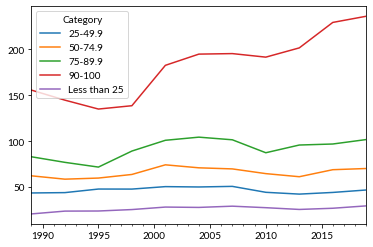

In [4]:
df = (pd.read_csv('../data/scf_wealth_median.csv')
        .set_index(['year', 'Category'])['Before_Tax_Income']
        .unstack())
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df.to_csv(data_dir / 'scfwealthmedian.csv', index_label='date', float_format='%g')
node = end_node3(df['Less than 25'], 'violet', percent=False)
write_txt(text_dir / 'scfwealthmedian_node1.txt', node)
node = end_node3(df['25-49.9'], 'red!20!orange!95!black', percent=False)
write_txt(text_dir / 'scfwealthmedian_node2.txt', node)
node = end_node3(df['50-74.9'], 'green!80!blue!85!black', percent=False)
write_txt(text_dir / 'scfwealthmedian_node3.txt', node)
node = end_node3(df['75-89.9'], 'red!80!black', percent=False)
write_txt(text_dir / 'scfwealthmedian_node4.txt', node)
node = end_node3(df['90-100'], 'blue!80!cyan!80!black', percent=False)
write_txt(text_dir / 'scfwealthmedian_node5.txt', node)
df.plot();

In [ ]:
yr = dtxt(df.index[-1])['year']
pryr = dtxt(df.index[0])['year']

g1val = df['90-100'].iloc[-1] * 1000
g1valpr = df['90-100'].iloc[0] * 1000
g1ch = g1val - g1valpr
g1pc = ((g1val / g1valpr) - 1) * 100

g2val = df['50-74.9'].iloc[-1] * 1000
g2valpr = df['50-74.9'].iloc[0] * 1000
g2ch = g2val - g2valpr
g2pc = ((g2val / g2valpr) - 1) * 100

g3val = df['25-49.9'].iloc[-1] * 1000
g3valpr = df['25-49.9'].iloc[0] * 1000
g3ch = g3val - g3valpr
g3pc = ((g3val / g3valpr) - 1) * 100

g4val = df['Less than 25'].iloc[-1] * 1000
g4valpr = df['Less than 25'].iloc[0] * 1000
g4ch = g4val - g4valpr
g4pc = ((g4val / g4valpr) - 1) * 100

text1 = (f'have a median annual income of \${g1val:,.0f} in {yr} and '+
         f'\${g1valpr:,.0f} in {pryr}, after adjusting for prices. '+
         f'Median income for the group increased \${g1ch:,.0f}, or '+
         f'{g1pc:.1f} percent, over the 30-year period. ')

write_txt(text_dir / 'income_wealthg1.txt', text1)
print(text1)

text2 = ('In contrast, families in the third quartile of wealth (50th to 74.9th '+
         f'percentiles, mean wealth of \$700,000 in {yr}, see '+
         '{\color{green!80!blue!85!black}\\textbf{---}}) have a median income of '+
         f'\${g2val:,.0f} in {yr} and \${g2valpr:,.0f} in '+
         f'{pryr}, an increase of \${g2ch:,.0f} ({g2pc:.1f} percent). '+
         'Median income for families in the second quartile (25th to 49.9th '+
         f'percentiles, mean wealth of \$236,000 in {yr}, see '+
         '{\color{red!20!orange!95!black}\\textbf{---}}) increased '+
         f'\${g3ch:,.0f} ({g3pc:,.1f} percent) to '+
         f'\${g3val:,.0f} in {yr}, '+
         f'from \${g3valpr:,.0f} in {pryr}. For '+
         'the bottom quarter of families by wealth (see {\color{violet}\\textbf{---}}), '+
         f'median income increased \${g4ch:,.0f} or {g4pc:,.1f} '+
         f'percent to \${g4val:,.0f}, '+
         f'over the 30 years ending {yr}. The bottom quarter of families '+
         f'have a negative mean wealth in {yr} and a median wealth of virtually zero. ')
write_txt(text_dir / 'income_wealthg2.txt', text2)
print('\n', text2)

In [ ]:
d = {'Black, non-Hispanic': 'Black', 
     'White, non-Hispanic': 'White'}

df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Net_Worth'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean.csv', index_label='date')

In [ ]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Before_Tax_Income'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean1.csv', index_label='date')

In [ ]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Financial_Assets'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean0.csv', index_label='date')

In [ ]:
df = pd.read_csv('../data/scf_race_mean.csv').set_index(['year', 'Category'])['Stock_Holdings'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracemean2.csv', index_label='date')

wval = df.White.iloc[-1] * 1000
bval = df.Black.iloc[-1] * 1000

df = pd.read_csv('../data/scf_race_have.csv').set_index(['year', 'Category'])['Stock_Holdings'].unstack()
df = df.rename(d, axis=1)
df.index = pd.to_datetime([f'{year}-07-01' for year in df.index])
df = df.round(1)
df.to_csv(data_dir / 'scfracehave.csv', index_label='date')

wp = df.White.iloc[-1]
bp = df.Black.iloc[-1]

yr = dtxt(df.index[-1])['year']

text = (f'In {yr}, among the {wp:.1f} percent of white families who own stocks, '+
        f'the average value of stock holdings is \${wval:,.0f}. The return on these '+
        'assets is a supplement to labor income and the assets themselves provide '+
        'cushion against unexpected expenses. Meanwhile, black families '+
        f'have relatively few financial assets; only {bp:.1f} percent of black '+
        f'families own stocks, with median stock holdings of \${bval:,.0f}.')
write_txt(text_dir / 'scfracestocks.txt', text)
text